# CE-40959: Deep Learning
## HW5 - Variational Autoencoder
#### 35 Points | Deadline: 4th of Khordad

---

Name: 
Seyed Shayan Nazemi


Student No.: 
98209037


---

**!!! CAUTION !!!**

To prevent Colab from disconnecting, insert the following javascript code into the inspector's console.

More info: 
[medium](https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0),
[stackoverflow](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)



```
function ClickConnect(){
  console.log("Working"); 
  document
    .querySelector("#top-toolbar > colab-connect-button")
    .shadowRoot
    .querySelector("#connect")
    .click()
}

setInterval(ClickConnect,60000)
```


In [0]:
#################### Problem 00 ####################
# Remember to write your Name and Student No. in the first cell :D
####################### End ########################

In [0]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm, trange

%matplotlib inline

In [0]:
LOG_INTERVAL = 200

BATCH_SIZE = 128
LEARNING_RATE = 5e-5

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1) Helper functions

In [0]:
def show(images, rows=1):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)

    cols = np.ceil(images.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (cols, rows)
    
    for i in range(images.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

## 2) Loading dataset

In [10]:
# Get MNIST dataloader

data_loader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

train_dataset = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)

print(train_dataset.data.max().item())  # But when using `train_loader` your data is normalized, learn more about transforms.ToTensor

255


## 3) Models

### 3.1) Autoencoder (7 pts)

In [0]:
# This class defines an Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()

        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)
        
        # Encoder part
        encoder_layers = list()
        ############### Problem 01 (2 pts) ################
        # Iterate over `encoder_dims` and create fully connected layers
        # Use ReLU activation function after each FC layer
        # Append all layers to `encoder_layers`
        layers = [input_dim, *encoder_dims]
        for idx, layer_dim in enumerate(layers):
            if idx < len(layers) - 1:
                encoder_layers.append(nn.Linear(layer_dim, layers[idx + 1]))
                encoder_layers.append(nn.ReLU())
        pass
        ####################### End ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Compute Z
        self.z_layer = None
        ################ Problem 02 (1 pts) ################
        # Define a fully connected layer that maps the output of previous part
        # to `z_dim` dimensions, store it in `self.z_layer`
        # No activation function is needed after this layer
        self.z_layer = nn.Linear(layers[-1], z_dim)
        pass
        ####################### End ########################

        # Decoder part
        decoder_layers = list()
        ################ Problem 03 (2 pts) ################
        layers = [z_dim, *decoder_dims]
        for idx, layer_dim in enumerate(layers):
            if idx < len(layers) - 1:
                decoder_layers.append(nn.Linear(layer_dim, layers[idx + 1]))
                decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(decoder_dims[-1], input_dim))
        # Define the decoder part (Use `decoder_dims`)
        # Use ReLU activation function after each FC layer (except the last one)
        # The last layer output should be of `input_dim` size
        # Append all layers to `decoder_layers`
        pass
        ####################### End ########################
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)
        ################ Problem 04 (1 pts) ################
        # Do the forward pass
        # Compute `x_hat` (reconstructed inputs), and `z` (the latent variables)

        encoded = self.encoder(dropped_out)
        z = self.z_layer(encoded)
        x_hat = self.decoder(z)

        pass
        ####################### End ########################
        return x_hat, z, None  # Last output is returned for the sake of compatibility

    def get_loss(self, x, x_hat, *_):
        ################ Problem 05 (1 pts) ################
        # Compute and return the MSE between x and x_hat
        return F.mse_loss(x_hat, x)
        ####################### End ########################

### 3.2) Variational Autoencoder (10 pts)

In [0]:
# This class defines a Variationl Autoencoder
# It inherits the AE class
class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)

        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore

        # Drouput, Encoder, and Decoder have been defined in AE class

        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None
        ################ Problem 06 (1 pts) ################
        # Define mu and logvar layers
        # Notice that we should have a logvar_layer, not a sigma_layer
        # Do not use any activation function
        self.mu_layer = nn.Linear(encoder_dims[-1], z_dim)
        self.logvar_layer = nn.Linear(encoder_dims[-1], z_dim)
        pass
        ####################### End ########################

    @staticmethod
    def reparameterize(mu, logvar):
        z = None
        ################ Problem 07 (3 pts) ################
        # Sample `z` from N(`mu`, e^`logvar`) in a way that the gradient can
        # backpropagate through this sampling operation
        
        rand = torch.normal(torch.zeros_like(mu), torch.ones_like(logvar))
        z = torch.add(mu, logvar.exp() * rand)
        pass
        ####################### End ########################
        return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)
        ################ Problem 08 (1 pts) ################
        # Do the forward pass
        # Compute `x_hat` (reconstructed inputs), `mu`, and `logvar` (outputs of
        # `mu_layer` and `logvar_layer` respectively)
        # Use reparameterization trick (the function you have implemented)
        encoded = self.encoder(dropped_out)
        
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)

        z = VAE.reparameterize(mu, logvar)

        x_hat = self.decoder(z)
        pass
        ####################### End ########################
        return x_hat, mu, logvar
    
    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0
        ################ Problem 09 (3 pts) ################
        # Compute the VAE loss (Assuming Guassian distribution for the decoder
        # output)
        MSE = F.mse_loss(x_hat, x)
        KLD = torch.sum(mu.pow(2) + logvar.exp() - logvar - 1) / 2
        pass
        ####################### End ########################
        return MSE + KLD

    def generate(self, n):
        samples = None
        ################ Problem 10 (2 pts) ################
        # Generate `n` random noises from N(0, I), feed it into the decoder and
        # generate `n` samples
        noises = torch.normal(mean=0, std=1, size=(n, self.z_dim), device=device)
        samples = self.decoder(noises)
        pass
        ####################### End ########################
        return samples

## 4) Run

### 4.1) Required functions (2 pts)

In [0]:
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    model.train()
    train_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)

        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss = model.get_loss(x, x_hat, mu, logvar)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))

    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [0]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)
            
            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [0]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """
    ################ Problem 11 (1 pts) ################
    # Send `model` to the desired device, defined in `device`
    model.to(device)
    pass
    ####################### End ########################

    optimizer = None
    ################ Problem 12 (1 pts) ################
    # Initialize a new Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    pass
    ####################### End ########################

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer, verbose)
        test(model, verbose)

### 4.2) Do run (1 pts)

In [26]:
ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim = 4 * [None]
################ Problem 13 (1 pts) ################
# Define 4 models, with these specifications:
# name           z_dim   encoder_dims    decoder_dims    training_n_epoch
# ae_low_dim     2       3 layers        3 layers        a
# vae_low_dim    2       same as above   same as above   a
# ae_high_dim    >= 20   3 layers        3 layers        b
# vae_high_dim   >= 20   same as above   same as above   b
# `a`, `b`, `encoder_dims`, and `decoder_dims` of your choice
# Then train all of 4 models

INPUT_SIZE = 784

## 'ae_low_dim' & 'vae_low_dim' models
a = 100
encoder_dims = [256, 64, 16]
z_dim = 2
decoder_dims = [16, 64, 256]

ae_low_dim = AE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)
vae_low_dim = VAE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)



## 'ae_high_dim' & 'vae_high_dim' models
b = 100
encoder_dims = [256, 128, 64]
z_dim = 32
decoder_dims = [64, 128, 256]

ae_high_dim = AE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)
vae_high_dim = VAE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)



## Training
print('\n\n\nTraining ae_low_dim begin')
run(ae_low_dim, a)
print('\n\n\nTraining vae_low_dim begin')
run(vae_low_dim, a)

print('\n\n\nTraining ae_high_dim begin')
run(ae_high_dim, b)
print('\n\n\nTraining vae_high_dim begin')
run(vae_high_dim, b)

pass
####################### End ########################

models = [ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim]




Training ae_low_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00048
    Train [51072/60000]	 | 	Loss: 0.00049
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0005

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00046
    Train [51072/60000]	 | 	Loss: 0.00045
==> Train | Average loss: 0.0005
==> Test  | Average loss: 0.0004

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00043
    Train [51072/60000]	 | 	Loss: 0.00042
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004




Training vae_low_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00093
    Train [51072/60000]	 | 	Loss: 0.00075
==> Train | Average loss: 0.0017
==> Test  | Average loss: 0.0007

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00059
    Train [51072/60000]	 | 	Loss: 0.00057
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0006

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00057
    Train [51072/60000]	 | 	Loss: 0.00054
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0006




Training ae_high_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00048
    Train [51072/60000]	 | 	Loss: 0.00048
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0005

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00041
    Train [51072/60000]	 | 	Loss: 0.00036
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0004

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00035
    Train [51072/60000]	 | 	Loss: 0.00032
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003




Training vae_high_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00843
    Train [51072/60000]	 | 	Loss: 0.00365
==> Train | Average loss: 0.0223
==> Test  | Average loss: 0.0025

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00168
    Train [51072/60000]	 | 	Loss: 0.00120
==> Train | Average loss: 0.0017
==> Test  | Average loss: 0.0018

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00099
    Train [51072/60000]	 | 	Loss: 0.00088
==> Train | Average loss: 0.0010
==> Test  | Average loss: 0.0014



## 5) Results

### 5.1) Representation (2 pts)

AE:


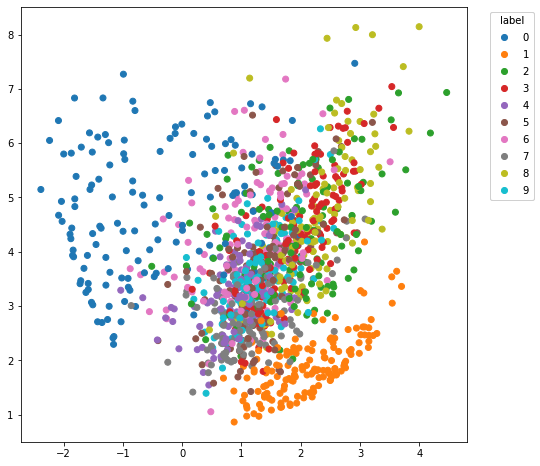


VAE:


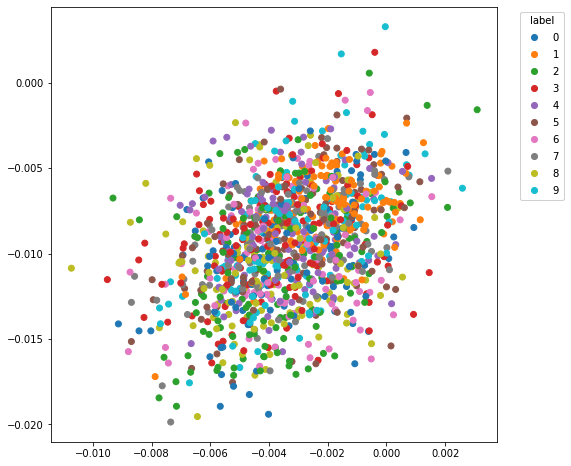

In [27]:
################ Problem 14 (2 pts) ################
# Run the current cell,
# Then answer the following cell's question in the cell itself
####################### End ########################

def visualize_2d(model, n_batch):
    assert model.z_dim == 2
    model.eval()

    n = BATCH_SIZE * n_batch
    Y, Z = torch.zeros(n, dtype=int), torch.zeros((n, model.z_dim))

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            if batch_idx >= n_batch:
                break
            current_range = range(batch_idx * BATCH_SIZE, (batch_idx+1) * BATCH_SIZE)
            Y[current_range] = y
            x = x.flatten(start_dim=1).to(device)
            _, z, _ = model(x)
            Z[current_range] = z.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=Y, cmap='tab10')
    legend = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.04, 1), title="label")
    ax.add_artist(legend)
    plt.show()

print('AE:')
visualize_2d(ae_low_dim, 10)

print('\nVAE:')
visualize_2d(vae_low_dim, 10)

#### Question

<div dir="rtl"> 
دو مدل
<tt>ae_low_dim</tt> 
و 
<tt>vae_low_dim</tt> 
(که هر دوی آن‌ها فضای نهانی به بعد ۲ دارند)
را در نظر بگیرید.
وقتی داده‌ای را به هر یک از این دو مدل ورودی می‌دهیم، هر کدام از آن‌ها پس از انجام عملیات مربوط به بخش
Encoder
خود، توزیع دومتغیره‌ای از نوع گاوسی روی فضای نهان ایجاد می‌کنند. برای تعدادی داده از مجموعه‌ی داده‌های تست میانگین این توزیع‌ها را روی یک نمودار رسم کردیم
(برای هر کدام از دو مدل نامبرده به صورت جداگانه).
در واقع هر کدام از این دو نمودار، نمودار بازنمایی در فضای نهان برای تعدادی داده است. رنگ هر نقطه نیز برچسب داده‌ی مربوط به هر بازنمایی را مشخص می‌کند.

الف) 
به نظر شما کدام مدل فضای نهان بهتری را یاد گرفته‌است؟
(با ذکر دلیل)

ب)
پیشبینی می‌کنید تصاویر میانی در
interpolation
بین دو تصویر، در کدام یک از این دو مدل تصاویر معنی‌دارتری هستند؟ چرا؟
(اگر با
interpolation
آشنایی ندارید، ابتدا آخرین بخش این
notebook
را انجام دهید.)




<b>پاسخ خود را در دو قسمت زیر بنویسید:</b>

الف)
...

ب)
...
</div>

### 5.2) Reconstruction (3 pts)

Data
torch.Size([20, 28, 28])


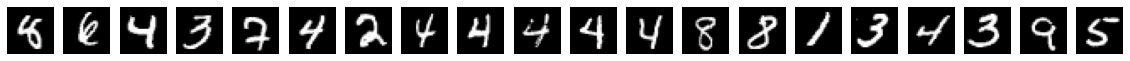

AE 2D
torch.Size([20, 784])


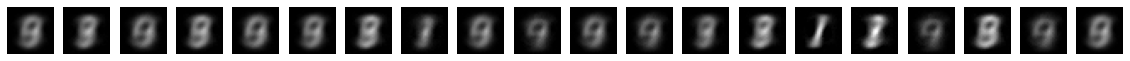

VAE 2D
torch.Size([20, 784])


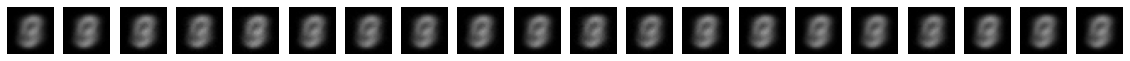

AE 32D
torch.Size([20, 784])


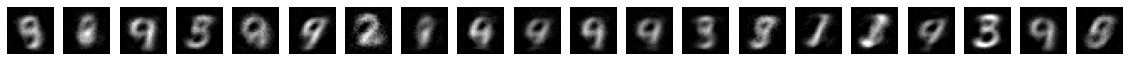

VAE 32D
torch.Size([20, 784])


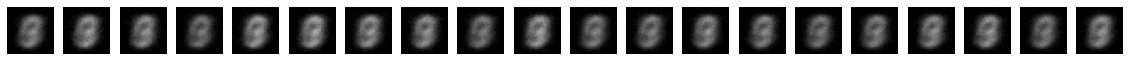

In [28]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]  # Get a batch and choose `n` of images
    print('Data')
    show(x.squeeze(1))

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu())

plot_reconstructions(models, 20)

################ Problem 15 (3 pts) ################
# Just run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################

### 5.3) Generation (3 pts)

VAE 32D
torch.Size([60, 784])


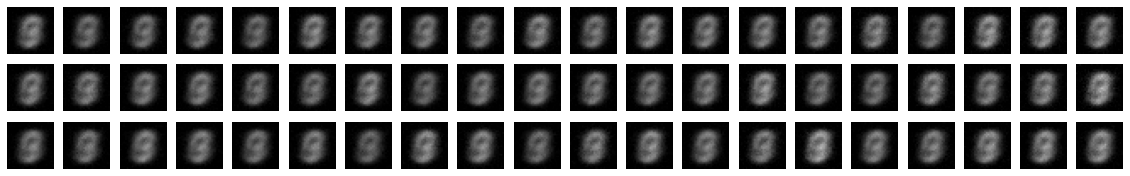

In [29]:
print('VAE %dD' % vae_high_dim.z_dim)
generated_imgs = vae_high_dim.generate(60)
show(generated_imgs.detach().cpu(), 3)

################ Problem 16 (3 pts) ################
# Just run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################

### 5.4) Interpolation (7 pts)

AE 2D
torch.Size([10, 784])


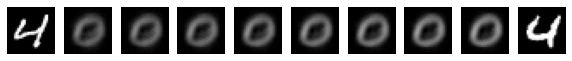

VAE 2D
torch.Size([10, 784])


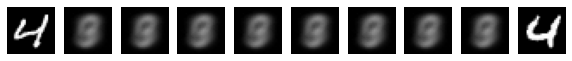

AE 32D
torch.Size([10, 784])


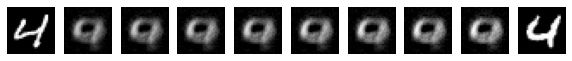

VAE 32D
torch.Size([10, 784])


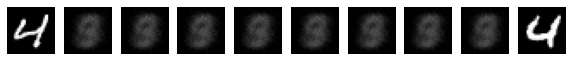

---

AE 2D
torch.Size([10, 784])


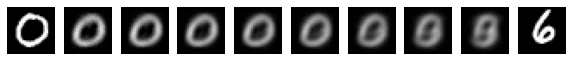

VAE 2D
torch.Size([10, 784])


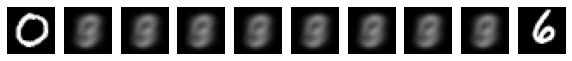

AE 32D
torch.Size([10, 784])


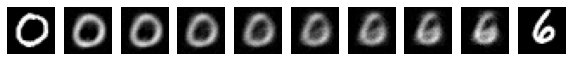

VAE 32D
torch.Size([10, 784])


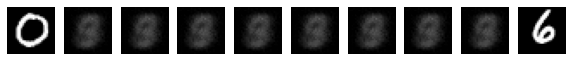

---

AE 2D
torch.Size([10, 784])


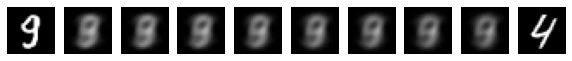

VAE 2D
torch.Size([10, 784])


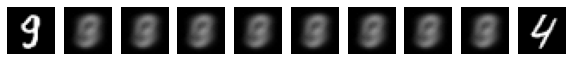

AE 32D
torch.Size([10, 784])


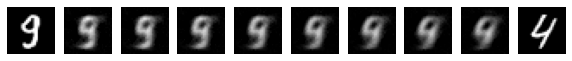

VAE 32D
torch.Size([10, 784])


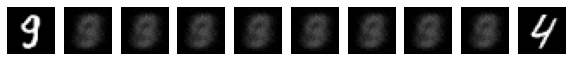

---

AE 2D
torch.Size([10, 784])


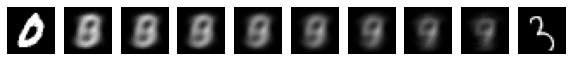

VAE 2D
torch.Size([10, 784])


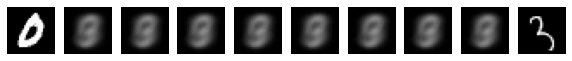

AE 32D
torch.Size([10, 784])


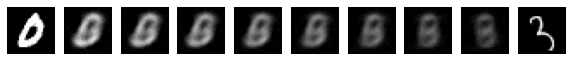

VAE 32D
torch.Size([10, 784])


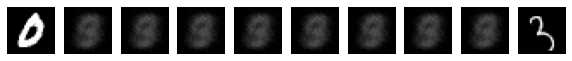

---

AE 2D
torch.Size([10, 784])


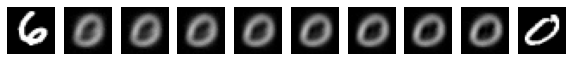

VAE 2D
torch.Size([10, 784])


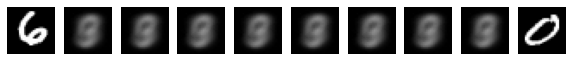

AE 32D
torch.Size([10, 784])


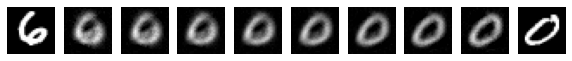

VAE 32D
torch.Size([10, 784])


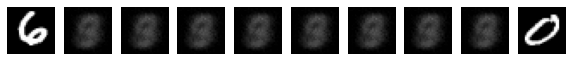

---



In [69]:
def plot_interpolations(models, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)
    
    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]
        
        for model in models:
            model.eval()
            images = None
            ################ Problem 17 (5 pts) ################
            # Find the representations of `img1, img2` in the latent space and call them `z1, z2`
            # Interpolate `n_cols` tensors (evenly spaced) between `z1` and `z2` (including both)
            # Feed these tensors to the decoder and get the resulting reconstruced images
            # Store these `n_cols` images in `images[1:-1]`
            # Set `images[0], images[-1]` to `img1, img2` respectively
            # Prepare `images` tensor to be passed into `show` function
            _, z1, _ = model(img1)
            _, z2, _ = model(img2)

            diff = (z2 - z1) / (n_cols - 1)
            z_interpolate = torch.tensor([], device=device)
            
            for j in range(1, n_cols - 1):
                z_interpolate = torch.cat((z_interpolate, z1 + j * diff))
            
            z_interpolate = z_interpolate.reshape(-1, model.z_dim)
            interpolated_images = model.decoder(z_interpolate)

            images = torch.cat((img1, *interpolated_images, img2)).reshape(-1, 784)
            images = images.detach().cpu()
            
            pass
            ####################### End ########################
            print('%s %dD' % (model.type_str, model.z_dim))
            show(images)
        print('---\n')

plot_interpolations(models, 5)

################ Problem 18 (2 pts) ################
# Run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################